In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
## read the edges (up to MAXSIZE) - I dropped the 'nodes' portion from the data files
MAXSIZE = 10

with open('../hospital-lyon-simple.txt', 'r') as file:
    for line in file:
        if line.strip() == 'edges':
            break
    edges = []
    for line in file:
        line = line.strip().strip('{}').replace('\'','').split(', ')
        if len(line)<=MAXSIZE:
            edges.append(line)

## report sizes
Lens = [len(x) for x in edges]
print(Counter(Lens))

## save edges by size in increasing order
E = []
for i in range(np.min(Lens),np.max(Lens)+1):
    E.append([set(x) for x in edges if len(x)==i])


Counter({2: 1107, 3: 657, 4: 58, 5: 2})


In [3]:
%%time
## count number of inclusions - brute force
def inclusions(E):
    counts = np.zeros((len(E)-1,len(E)), dtype=int)
    for i in range(0,len(E)-1):
        for j in range(i+1,len(E)):
            for a in E[i]:
                for b in E[j]:
                    if a.issubset(b):
                        counts[i,j] +=1
    return counts 

GT = inclusions(E)
GT

CPU times: user 55.3 ms, sys: 0 ns, total: 55.3 ms
Wall time: 53.5 ms


array([[   0, 1938,  347,   20],
       [   0,    0,  190,   12],
       [   0,    0,    0,    0]])

In [4]:
## naive CL function - simple HG
## from nodes, generate num_edges unique edges of size=size
def naive_CL(nodes, num_edges, size):
    CL = []
    ctr = 0
    L = len(nodes)
    while ctr < num_edges:
        x = set([nodes[x] for x in np.random.randint(0,L,size)])
        if len(x)!=size:
            while len(x)!=size:
                x = set([nodes[x] for x in np.random.randint(0,L,size)])
        if x not in CL:
            CL.append(x)
            ctr += 1
    return CL


In [5]:
%%time
## given: edges
nodes = [node for edge in edges for node in edge]
Lens = [len(x) for x in edges]
ctr = Counter(Lens)
REP = 10 
A = np.zeros((len(ctr)-1,len(ctr)), dtype=int)

for i in range(REP):    
    CL = []
    ## edges in increasing sizes
    for s in np.sort(list(ctr.keys())): 
        CL.append(naive_CL(nodes, ctr[s], s))
    A += inclusions(CL)

np.set_printoptions(suppress=True)
A = A/REP
print(A)

[[   0.  1411.7  246.7   15. ]
 [   0.     0.    11.8    1.1]
 [   0.     0.     0.     0. ]]
CPU times: user 1.32 s, sys: 61.9 ms, total: 1.38 s
Wall time: 1.31 s


## All datasets - row sums

In [6]:
## read the edges only - I dropped the 'nodes' portion from the data files
datasets = ['NDC-substances-simple.txt',
'contact-high-school-simple.txt',
'contact-primary-school-simple.txt',
'diseasome-simple.txt',
'disgenenet-simple.txt',
'email-enron-simple.txt',
'email-eu-simple.txt',
'hospital-lyon-simple.txt',
'tags-ask-ubuntu-simple.txt',
'tags-math-sx-simple.txt',
'congress-bills-simple.txt']

In [ ]:
## this is slow for a few datasets
ROWCOUNTS = []
REP = 1
MAXSIZE = 10

for ds in datasets:
    fn = '../'+ds
    with open(fn, 'r') as file:
        for line in file:
            if line.strip() == 'edges':
                break
        edges = []
        for line in file:
            line = line.strip().strip('{}').replace('\'','').split(', ')
            if len(line)<=MAXSIZE:
                edges.append(line)

    ## edge sizes
    Lens = [len(x) for x in edges]
    print('running:',ds,'edge sizes:',Counter(Lens),'\n')
    
    ## save edges by size in increasing order and compute inclusions
    E = []
    for i in range(np.min(Lens),np.max(Lens)+1):
        E.append([set(x) for x in edges if len(x)==i])
    GT = inclusions(E)
    
    ## Chung-Lu (simple)
    nodes = [node for edge in edges for node in edge]
    ctr = Counter(Lens)
    A = np.zeros((len(ctr)-1,len(ctr)), dtype=int)
    for i in range(REP):    
        CL = []
        ## edges in increasing sizes
        for s in np.sort(list(ctr.keys())): 
            CL.append(naive_CL(nodes, ctr[s], s))
        A += inclusions(CL)
    np.set_printoptions(suppress=True)
    A = A/REP

    ## ratio of row sums
    l = np.sort(list(ctr.keys()))
    gt = GT.sum(axis=1)
    cl = A.sum(axis=1)
    for i in range(len(gt)):
        if gt[i]>0:
            ROWCOUNTS.append([ds,l[i],(gt[i]-cl[i])/gt[i]])

df = pd.DataFrame(ROWCOUNTS, columns=['dataset','size','ratio'])
df.head()

running: NDC-substances-simple.txt edge sizes: Counter({1: 3642, 2: 1130, 3: 745, 4: 535, 5: 500, 8: 360, 7: 335, 6: 318, 10: 305, 9: 297}) 

running: contact-high-school-simple.txt edge sizes: Counter({2: 5498, 3: 2091, 4: 222, 5: 7}) 

running: contact-primary-school-simple.txt edge sizes: Counter({2: 7748, 3: 4600, 4: 347, 5: 9}) 

running: diseasome-simple.txt edge sizes: Counter({1: 167, 2: 153, 3: 92, 4: 26, 5: 25, 6: 9, 8: 3, 7: 2, 9: 2, 10: 1}) 

running: disgenenet-simple.txt edge sizes: Counter({1: 397, 2: 157, 3: 139, 4: 93, 6: 74, 5: 66, 7: 64, 9: 52, 10: 42, 8: 37}) 

running: email-enron-simple.txt edge sizes: Counter({2: 809, 3: 317, 4: 138, 5: 63, 1: 55, 6: 43, 7: 27, 8: 22, 10: 11, 9: 6}) 

running: email-eu-simple.txt edge sizes: Counter({2: 12753, 3: 4938, 4: 2294, 5: 1359, 6: 888, 1: 628, 7: 551, 8: 352, 9: 272, 10: 188}) 

running: hospital-lyon-simple.txt edge sizes: Counter({2: 1107, 3: 657, 4: 58, 5: 2}) 

running: tags-ask-ubuntu-simple.txt edge sizes: Counter(

In [ ]:
DS = set(df['dataset'])
for ds in DS:
    if ds != 'NDC-substances-simple.txt':
        D = df[df['dataset']==ds]
        plt.plot(D['size'],D['ratio'],'o--',label=ds)
plt.xlabel('size of smaller edge')
plt.ylabel('Inclusion ratio: (#GT-#CL)/#GT')
plt.legend();

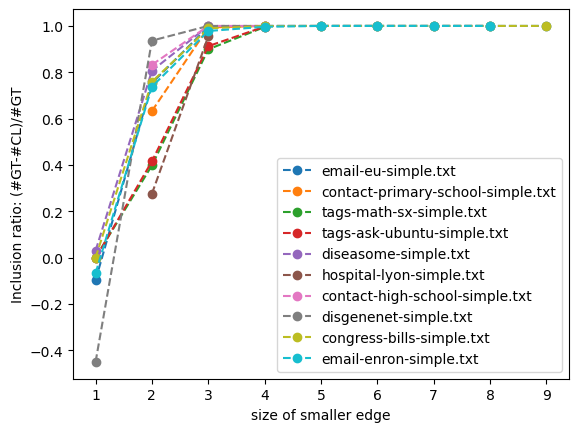

In [13]:
DS = set(df['dataset'])
for ds in DS:
    if ds != 'NDC-substances-simple.txt':
        D = df[df['dataset']==ds]
        plt.plot(D['size'],D['ratio'],'o--',label=ds)
plt.xlabel('size of smaller edge')
plt.ylabel('Inclusion ratio: (#GT-#CL)/#GT')
plt.legend();